In [ ]:
# Connecting to MyDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Required Libraries
import pandas as pd
import os
import numpy as np
from PIL import Image
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models.swin_transformer import swin_s
import torch.nn.functional as F
from torchvision.utils import make_grid

warnings.filterwarnings('ignore')

In [ ]:
print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

2.3.0+cu121
cuda:0


In [ ]:
# Defining the path to the directory containing the image folders
path = "drive/MyDrive/Nazir Folder/dogs_breed"

# Dictionary to store image paths and labels
data = {"imgpath": [], "labels": []}

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    # Iterate through each image file in the current category
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        # Append the image path and its corresponding label to the data dictionary
        data["imgpath"].append(fpath)
        data["labels"].append(folder)

df = pd.DataFrame(data)
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

print("-------------Fetch files into a data frame-----------")
print(df.head())
print("-------------Path to an image file------------------")
print(df.loc[175]['imgpath'])
print("-----------Number of images per category--------------")
print(df.labels.value_counts())


-------------Fetch files into a data frame-----------
                                             imgpath   labels  encoded_labels
0  drive/MyDrive/Nazir Folder/dogs_breed/Bulldog/...  Bulldog               1
1  drive/MyDrive/Nazir Folder/dogs_breed/Bulldog/...  Bulldog               1
2  drive/MyDrive/Nazir Folder/dogs_breed/Bulldog/...  Bulldog               1
3  drive/MyDrive/Nazir Folder/dogs_breed/Bulldog/...  Bulldog               1
4  drive/MyDrive/Nazir Folder/dogs_breed/Bulldog/...  Bulldog               1
-------------Path to an image file------------------
drive/MyDrive/Nazir Folder/dogs_breed/Siberian Husky/husky-gallery-outdoors-1-min.jpeg
-----------Number of images per category--------------
labels
Bulldog                154
Dachshund              133
Siberian Husky         118
poodle                 107
Golden Retriever       103
Australian Shepherd    100
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and validation sets
train_df, valid_df = train_test_split(df, train_size=0.80, shuffle=True, random_state=124)

# Reset the index of the DataFrames after the split
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print("#############Train Split###################")
print(train_df.head(5))
print(train_df.shape)
print("#############Test Split###################")
print(valid_df.head(5))
print(valid_df.shape)


#############Train Split###################
                                             imgpath               labels  \
0  drive/MyDrive/Nazir Folder/dogs_breed/Golden R...     Golden Retriever   
1  drive/MyDrive/Nazir Folder/dogs_breed/Australi...  Australian Shepherd   
2  drive/MyDrive/Nazir Folder/dogs_breed/Dachshun...            Dachshund   
3  drive/MyDrive/Nazir Folder/dogs_breed/Bulldog/...              Bulldog   
4  drive/MyDrive/Nazir Folder/dogs_breed/poodle/3...               poodle   

   encoded_labels  
0               3  
1               0  
2               2  
3               1  
4               5  
(572, 3)
#############Test Split###################
                                             imgpath               labels  \
0  drive/MyDrive/Nazir Folder/dogs_breed/Dachshun...            Dachshund   
1  drive/MyDrive/Nazir Folder/dogs_breed/Australi...  Australian Shepherd   
2  drive/MyDrive/Nazir Folder/dogs_breed/Australi...  Australian Shepherd   
3  drive/MyDr

In [ ]:
from torchvision import transforms

# Define image transformations for training and validation datasets
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class DogsBreedDataset(Dataset):
    def __init__(self, img_data, transform=None):
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = self.img_data.loc[index]['imgpath']
        imge = Image.open(img_name).convert('RGB')

        # Check the number of channels in the image
        if imge.mode != 'RGB':
            # If the image doesn't have RGB mode, raise an exception
            raise ValueError(f"Image {img_name} does not have RGB mode.")

        # Resize the image
        image = imge.resize((224, 224))

        if self.transform is not None:
            image = self.transform(image)

        label = torch.tensor(self.img_data.loc[index]['encoded_labels'])
        return image, label

# Create datasets
training_data = DogsBreedDataset(train_df, transform=image_transforms['train'])
validation_data = DogsBreedDataset(valid_df, transform=image_transforms['valid'])


In [ ]:
from torch.utils.data import DataLoader

# Define batch sizes
train_batch_size = 200
val_batch_size = 100

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=val_batch_size, shuffle=True)

# Print information about the data loaders
print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset), train_batch_size, len(train_dataloader)))
print(">> Number of Validation Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset), val_batch_size, len(test_dataloader)))

# Get one batch of data from the training data loader
one_batch = iter(train_dataloader)
train_features, train_labels = next(one_batch)

# Print the shapes of the features and labels in the batch
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")


>> Number of Train Data : 572 -- Batch Size : 200 -- Number of Batch : 3 
>> Number of Validation Data : 143 -- Batch Size : 100 -- Number of Batch : 2 
----------Batch Shape--------
Feature batch shape: torch.Size([200, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([200])


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_name = 'google/vit-base-patch16-224'
model = AutoModelForImageClassification.from_pretrained(model_name)

In [ ]:
print(f'Model: {model}')

Model: ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

In [ ]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(768, 6)
)
model = model.to(device)

In [ ]:
print(f'Head: {model}')

Head: ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear

In [ ]:
# Move the model to the specified device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

print("Model is ready for training.")

Model is ready for training.


In [ ]:
import torch

def train_model(model, optimizer, criterion, data_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for i, (inputs, labels) in enumerate(data_loader):  # Unpack data directly
        # Move inputs and labels to the appropriate device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).logits  # Accessing logits if using Hugging Face model

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)

    # Calculate average loss and accuracy
    avg_train_loss = running_loss / len(data_loader.dataset)
    avg_train_acc = (correct / len(data_loader.dataset)) * 100

    print(f">>> Train loss: {avg_train_loss:.4f} ---- Accuracy Train: {avg_train_acc:.2f}%")

    return avg_train_loss, avg_train_acc


In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import label_binarize

def test_model(model, criterion, data_loader, device):
    model.eval()

    val_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move inputs and labels to the appropriate device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs).logits  # Accessing logits if using Hugging Face model
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Collect all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average validation loss and accuracy
    avg_val_acc = (correct / len(data_loader.dataset)) * 100
    avg_val_loss = val_loss / len(data_loader.dataset)

    # Calculate precision, recall, sensitivity, specificity, MCC, and AUC
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    sensitivity = recall_score(all_labels, all_predictions, average='macro')
    specificity = recall_score(all_labels, all_predictions, average='macro')
    mcc = matthews_corrcoef(all_labels, all_predictions)

    # AUC calculation
    if len(set(all_labels)) > 2:  # Multiclass
        auc = roc_auc_score(label_binarize(all_labels, classes=np.unique(all_labels)), label_binarize(all_predictions, classes=np.unique(all_labels)), average='macro', multi_class='ovr')
    else:  # Binary
        auc = roc_auc_score(all_labels, all_predictions)

    # Print scores
    print(">>> Validation loss {:.4f} ---- Validation Accuracy {:.2f}%".format(avg_val_loss, avg_val_acc))
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Area Under Curve: {auc:.4f}")

    return avg_val_loss, avg_val_acc


In [ ]:
num_epochs = 5
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    print(f"------------------ Training Epoch {epoch+1} ------------------")
    train_loss, train_acc = train_model(model, optimizer, criterion, train_dataloader, device)
    val_loss, val_acc = test_model(model, criterion, test_dataloader, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

------------------ Training Epoch 1 ------------------
>>> Train loss: 1.5437 ---- Accuracy Train: 45.63%
>>> Validation loss 1.1003 ---- Validation Accuracy 81.82%
Recall: 0.8182
Precision: 0.8273
Sensitivity: 0.8172
Specificity: 0.8172
Matthews Correlation Coefficient: 0.7826
Area Under Curve: 0.8903
------------------ Training Epoch 2 ------------------
>>> Train loss: 0.9069 ---- Accuracy Train: 89.86%
>>> Validation loss 0.6592 ---- Validation Accuracy 92.31%
Recall: 0.9231
Precision: 0.9254
Sensitivity: 0.9253
Specificity: 0.9253
Matthews Correlation Coefficient: 0.9074
Area Under Curve: 0.9549
------------------ Training Epoch 3 ------------------
>>> Train loss: 0.5202 ---- Accuracy Train: 94.93%
>>> Validation loss 0.4106 ---- Validation Accuracy 95.10%
Recall: 0.9510
Precision: 0.9526
Sensitivity: 0.9569
Specificity: 0.9569
Matthews Correlation Coefficient: 0.9411
Area Under Curve: 0.9735
------------------ Training Epoch 4 ------------------
>>> Train loss: 0.3314 ---- Accur

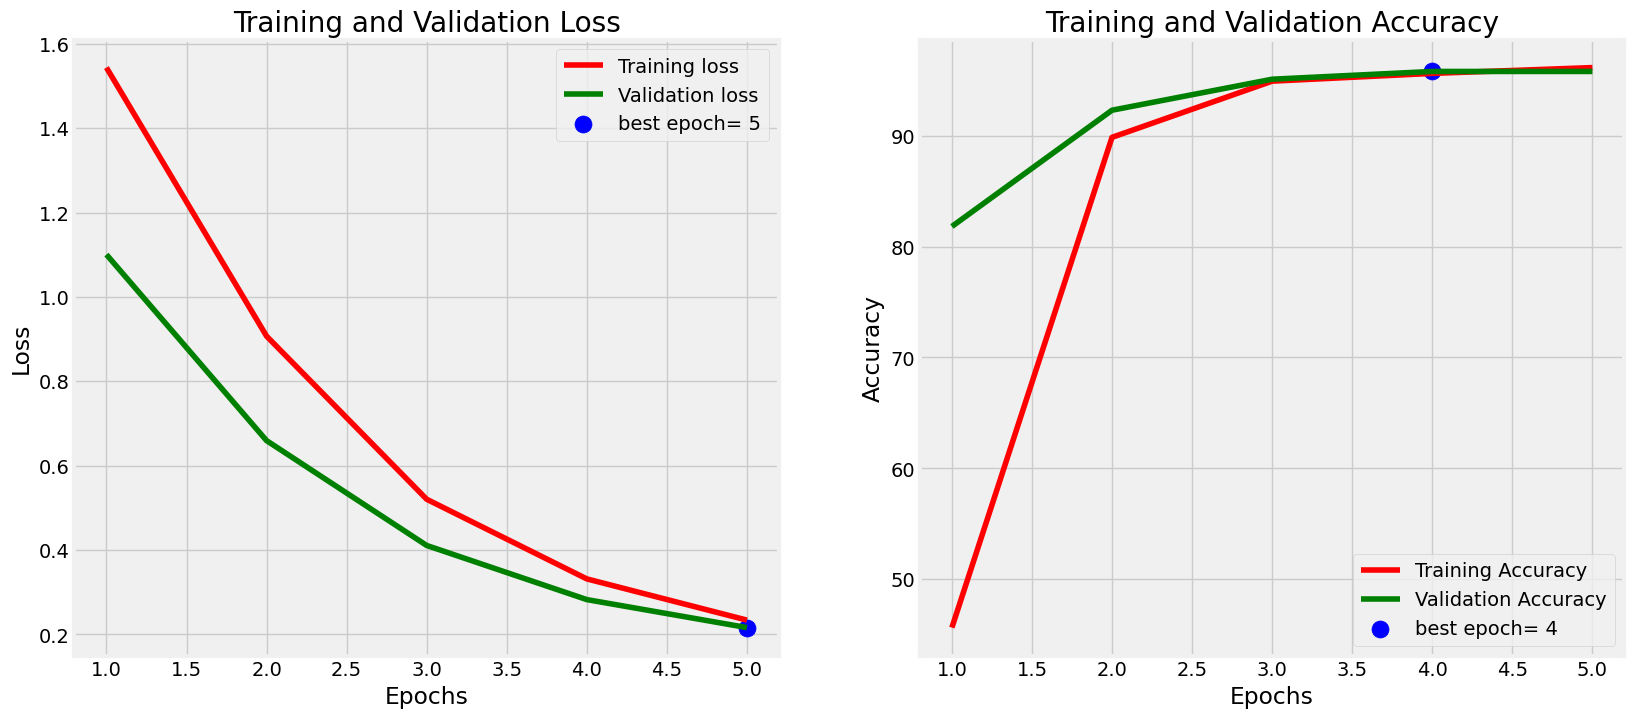

In [ ]:
tr_acc = history["train_acc"]
tr_loss = history["train_loss"]
val_acc = history["val_acc"]
val_loss = history["val_loss"]


index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import label_binarize

def test_model1(model, criterion, data_loader, device):
    model.eval()

    val_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate predictions and probabilities
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Collect all labels, predictions, and probabilities for metric calculation and ROC curve
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate average validation loss and accuracy
    avg_val_acc = (correct / len(data_loader.dataset)) * 100
    avg_val_loss = val_loss / len(data_loader.dataset)

    # Calculate precision, recall, MCC
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    mcc = matthews_corrcoef(all_labels, all_predictions)

        # ROC Curve
    num_classes = len(np.unique(all_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    all_probs_array = np.array(all_probs)  # Convert list of arrays to numpy array
    for i in range(num_classes):
        # Access correct elements and reshape if necessary
        probs_for_class_i = all_probs_array[:, i]  # Access probabilities for class i
        fpr[i], tpr[i], _ = roc_curve(label_binarize(all_labels, classes=np.unique(all_labels))[:, i], probs_for_class_i)
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Plot ROC Curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print scores
    print(">>> Validation loss {:.4f} ---- Validation Accuracy {:.2f}%".format(avg_val_loss, avg_val_acc))
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    return avg_val_loss, avg_val_acc


In [ ]:
# test_model1(model, criterion, test_dataloader, device)